In [272]:
import json
import exifread
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import env
from utils import KaggleCameraDataset, progress_iter, RNG

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## validation set

In [273]:
N_VAL_PER_CLASS = 48
val, no_val = [], []

### get best images from Gleb's val set (quality $\geq$ 95)

In [274]:
with open('../data/glebs_val_stats.json') as f:
    glebs_val_stats = json.load(f)

In [275]:
gv_yes, gv_no = [], []
for i, d in sorted(glebs_val_stats.items()):
    if d['quality'] and d['quality'] >= 95:
        gv_yes.append((d['x_fpath'], d['y']))
    else:
        gv_no.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))
print len(gv_yes), len(gv_no)

325 9


In [276]:
val += gv_yes
no_val += gv_no

[45, 37, 14, 28, 30, 18, 44, 42, 36, 31]

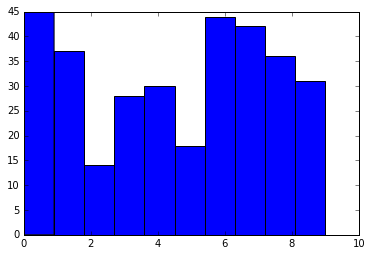

In [277]:
VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
VAL_CLASSES

### get best images from alex firsov val set (quality $\geq$ 95)

In [278]:
with open('../data/alex_firsov_stats.json') as f:
    alex_firsov_stats = json.load(f)

In [279]:
af_yes, af_no = [], []
for i, d in sorted(alex_firsov_stats.items()):
    d['y'] = 4  # !!!!!!!!!!!!
    d['x_fpath'] = d['x_fpath'].replace('Motorola-Droid-Maxx', 'Motorola-X')
    if d['quality'] and d['quality'] >= 95:
        af_yes.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))
    else:
        af_no.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))
print len(af_yes), len(af_no)

333 11


In [280]:
RNG(seed=1337).shuffle(af_yes)

In [281]:
val += map(lambda (x,y,q,r,rv): (x,y), af_yes[:(N_VAL_PER_CLASS - VAL_CLASSES[4])])
no_val += af_no
no_val += af_yes[(N_VAL_PER_CLASS - VAL_CLASSES[4]):]

[45, 37, 14, 28, 48, 18, 44, 42, 36, 31]

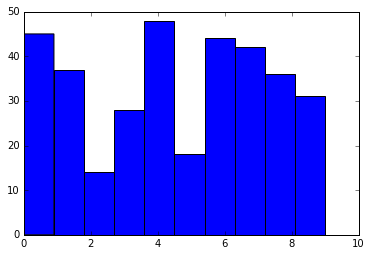

In [282]:
VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
VAL_CLASSES

### fill other classes with $\geq$ 95 from esato

In [283]:
with open('../data/esato_stats.json') as f:
    esato_stats = json.load(f)

In [284]:
es_yes, es_no = [], []
for i, d in sorted(esato_stats.items()):
    if d['x_fpath'].endswith('jpg.1'):
        continue
    if d['quality'] and d['quality'] >= 95:
        es_yes.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))
    else:
        es_no.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))
print len(es_yes), len(es_no)

1063 89


[2, 0, 15, 0, 362, 0, 6, 0, 546, 132]

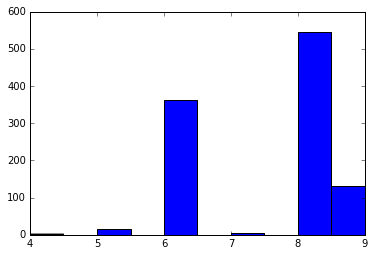

In [285]:
map(int, plt.hist(zip(*es_yes)[1])[0])

#### add all with valid resolution first

[1, 0, 0, 0, 0, 0, 89, 0, 0, 4]

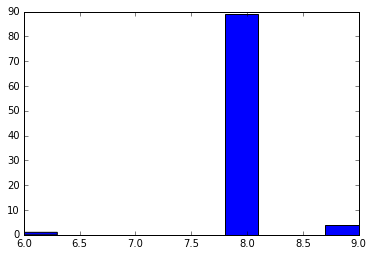

In [286]:
map(int, plt.hist(zip(*filter(lambda (x,y,q,r,rv): rv, es_yes))[1])[0])

In [287]:
es_yes_valid = filter(lambda (x,y,q,r,rv): rv, es_yes)
es_yes_not_valid = filter(lambda (x,y,q,r,rv): not rv, es_yes)

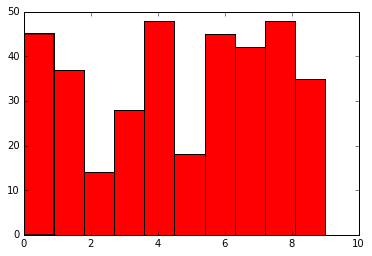

In [288]:
for x,y,q,r,rv in es_yes_valid:
    VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
    if VAL_CLASSES[y] < N_VAL_PER_CLASS:
        val.append((x, y))
    else:
        no_val.append((x,y,q,r,rv))

[45, 37, 14, 28, 48, 18, 45, 42, 48, 35]

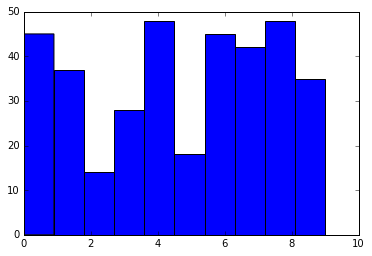

In [289]:
VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
VAL_CLASSES

#### now add with incorrect resolution (UPD: add incorrect resolution -> train for further filtering)

In [290]:
RNG(seed=42).shuffle(es_yes_not_valid)
for x,y,q,r,rv in es_yes_not_valid:
    no_val.append((x,y,q,r,rv))    

[45, 37, 14, 28, 48, 18, 45, 42, 48, 35]

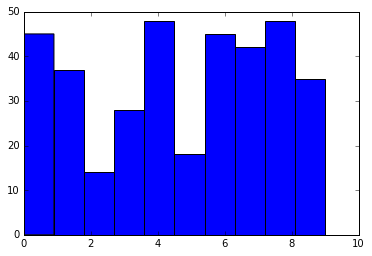

In [291]:
VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
VAL_CLASSES

In [292]:
no_val += es_no

## training set
### load Gleb's train and remove $\lt$ 93

In [293]:
with open('../data/orig_stats.json') as f:
    train_stats = json.load(f)
for x,y,q in train_stats:
    no_val.append((x,y,q,None,True))

In [294]:
QUALITY_THRESHOLD = 93

In [295]:
with open('../data/glebs_train_stats.json') as f:
    glebs_train_stats = json.load(f)

In [296]:
print len(filter(lambda q: q >= QUALITY_THRESHOLD, [v['quality'] for k, v in glebs_train_stats.items()]))

9229


In [297]:
print len(filter(lambda q: not q or q < QUALITY_THRESHOLD, [v['quality'] for k, v in glebs_train_stats.items()]))

1775


In [298]:
print len(filter(lambda q: not q or q < QUALITY_THRESHOLD, [q for x,y,q in train_stats]))

1


In [299]:
train = []
for x,y,q,r,rv in no_val:
    if q >= QUALITY_THRESHOLD:
        train.append((x,y,q,r,rv))
for i, d in sorted(glebs_train_stats.items()):
    if d['quality'] >= QUALITY_THRESHOLD:
        train.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))

### NEW: add artgor data

In [300]:
with open('../data/artgor_stats.json') as f:
    artgor_stats = json.load(f)
for i, d in sorted(artgor_stats.items()):
    if d['quality'] >= QUALITY_THRESHOLD:
        train.append((d['x_fpath'], d['y'], d['quality'], d['res'], d['res_valid']))

In [301]:
len(train)

13897

[1050, 874, 904, 1002, 1989, 1514, 1834, 1385, 2129, 1216]

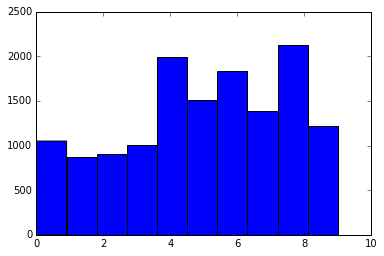

In [302]:
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

In [303]:
M = max(TRAIN_CLASSES)
m = min(TRAIN_CLASSES)
(M - m) / float(M)

0.5894786284640676

### remove the most "unlikely resolutions", i.e. with maximal $d(\text{img}, \text{class})=\min_{r \in R_{\text{class}}}\min\{\|r_{\text{img}}-r\|_2, \|r_{\text{img}}-r_{\text{rotated}}\|_2\}$, $r=\begin{pmatrix} h \\ w \end{pmatrix}$

In [304]:
def resolutions(): # with all possible rotations
    return [
        [(1520, 2688), (2688, 1520)],
        [(3024, 4032), (4032, 3024)],
        [(2432, 4320), (4320, 2432)],
        [(1040, 780), (3088, 4130), (4130, 3088), (3120, 4160), (4160, 3120)],
        [(3120, 4160), (4160, 3120), (4160, 2340)],
        [(4128, 2322)],
        [(4128, 2322)],
        [(6000, 4000)],
        [(3264, 2448)],
        [(3264, 2448)],
    ]

In [305]:
def distance(res, c):
    return min(min([np.sqrt((res[0]-r[0])**2+(res[1]-r[1])**2) for r in resolutions()[c]]),
               min([np.sqrt((res[0]-r[1])**2+(res[1]-r[0])**2) for r in resolutions()[c]]))

In [306]:
len(filter(lambda (x,y,q,r,rv): rv, train)) # with correct resolutions

5314

In [307]:
len(filter(lambda (x,y,q,r,rv): not rv, train))

8583

### e.g., "incorrect iphone4s resolutions"

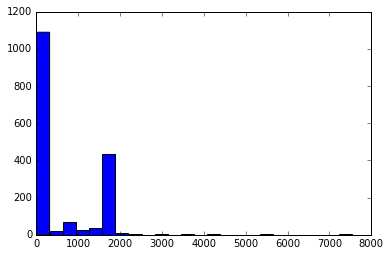

In [308]:
incorrect_iphone4s = filter(lambda (x,y,q,r,rv): not rv and y == 8, train)
dists = map(lambda (x,y,q,r,rv): distance(r, 8), incorrect_iphone4s)
dists.sort()
plt.hist(dists, bins=24);

In [309]:
dists[::-1][40:50]

[1655.9619560847405,
 1631.9571072794774,
 1593.5294161075283,
 1584.788944938726,
 1584.0012626257594,
 1580.0,
 1580.0,
 1580.0,
 1580.0,
 1580.0]

In [310]:
sum(np.asarray(dists) > 1581.)/float(len(dists))

0.026346604215456676

In [311]:
sum(np.asarray(dists) > 1.)/float(len(dists)) # 0 means simply landscape photos

0.38114754098360654

In [312]:
incorrect_iphone4s.sort(key=lambda (x,y,q,r,rv): -distance(r,8))
incorrect_iphone4s[42:50]

[(u'../data/glebs-train/train/iPhone-4s/38290361134_d74e19efa3_o.jpg',
  8,
  96,
  [1698, 1858],
  False),
 (u'../data/esato-com/train/iPhone-4s/201303121858b24wEX.jpg',
  8,
  96,
  [2498, 4848],
  False),
 (u'../data/esato-com/train/iPhone-4s/201212020931H43XZV.jpg',
  8,
  96,
  [2446, 4848],
  False),
 (u'../data/glebs-train/train/iPhone-4s/24694324078_3435e21cd7_o.jpg',
  8,
  99,
  [1500, 2000],
  False),
 (u'../data/glebs-train/train/iPhone-4s/24694337928_76c70409b6_o.jpg',
  8,
  99,
  [1500, 2000],
  False),
 (u'../data/glebs-train/train/iPhone-4s/24694339268_a86b1ce6cd_o.jpg',
  8,
  99,
  [1500, 2000],
  False),
 (u'../data/glebs-train/train/iPhone-4s/24694350208_4cf3f1ea52_o.jpg',
  8,
  99,
  [1500, 2000],
  False),
 (u'../data/glebs-train/train/iPhone-4s/24694359098_9ae4375750_o.jpg',
  8,
  99,
  [1500, 2000],
  False)]

13246


[1050, 874, 904, 1002, 1989, 1514, 1834, 1385, 1478, 1216]

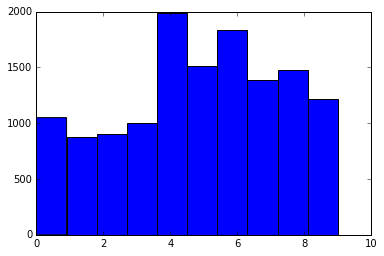

In [313]:
train = filter(lambda (x,y,q,r,rv): y != 8 or (y == 8 and (rv or (not rv and distance(r, 8) < 1.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### incorrect Samsung-Galaxy-S4 resolutions

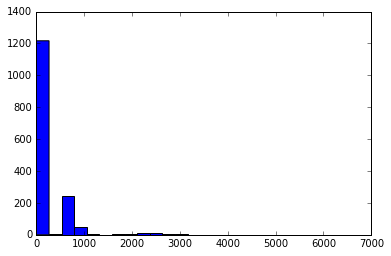

In [314]:
incorrect_S4 = filter(lambda (x,y,q,r,rv): not rv and y == 6, train)
dists = map(lambda (x,y,q,r,rv): distance(r, 6), incorrect_S4)
dists.sort()
plt.hist(dists, bins=24);

12907


[1050, 874, 904, 1002, 1989, 1514, 1495, 1385, 1478, 1216]

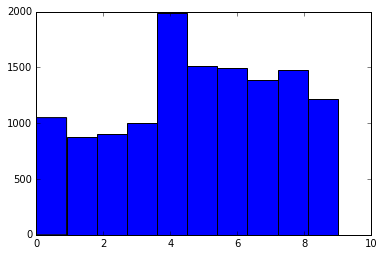

In [315]:
train = filter(lambda (x,y,q,r,rv): y != 6 or (y == 6 and (rv or (not rv and distance(r, 6) < 1.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### incorrect Motorola-X resolutions

1713


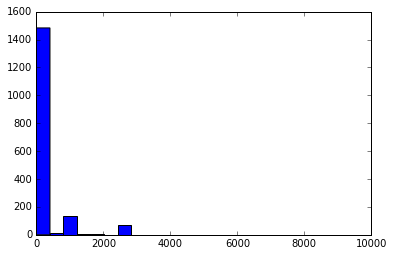

In [316]:
c = 4
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [317]:
c = 4
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
print dists[500:510]

[184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924, 184.56435192094924]


In [318]:
incorrect.sort(key=lambda (x,y,q,r,rv): distance(r,4))
incorrect[500:510]

[(u'../data/glebs-train/train/Motorola-X/24800884010_e8a4414391_o.jpg',
  4,
  95,
  [2432, 4320],
  False),
 (u'../data/glebs-train/train/Motorola-X/24801148050_c2e5e2bc3b_o.jpg',
  4,
  95,
  [2432, 4320],
  False),
 (u'../data/glebs-train/train/Motorola-X/24886935300_260bef7313_o.jpg',
  4,
  95,
  [2432, 4320],
  False),
 (u'../data/glebs-train/train/Motorola-X/24908486461_4b67737261_o.jpg',
  4,
  95,
  [2432, 4320],
  False),
 (u'../data/glebs-train/train/Motorola-X/24917793486_a84a24dd28_o.jpg',
  4,
  95,
  [4320, 2432],
  False),
 (u'../data/glebs-train/train/Motorola-X/24978362412_198f73d5df_o.jpg',
  4,
  95,
  [2432, 4320],
  False),
 (u'../data/glebs-train/train/Motorola-X/25003330771_e554aa4e98_o.jpg',
  4,
  95,
  [4320, 2432],
  False),
 (u'../data/glebs-train/train/Motorola-X/25003677326_f67c4fb2fa_o.jpg',
  4,
  95,
  [2432, 4320],
  False),
 (u'../data/glebs-train/train/Motorola-X/25033310134_a18f64e4e0_o.jpg',
  4,
  95,
  [4320, 2432],
  False),
 (u'../data/glebs-t

### add images with Droid Maxx resolution to its class
### UPD: no

In [319]:
new_train = []
for x,y,q,r,rv in train:
    if y == 4 and r and distance(r, 2) < 0.01:
        new_train.append((x,2,q,r,rv))
    else:
        new_train.append((x,y,q,r,rv))
train = new_train

### filter Moto X

12653


[1050, 874, 2042, 1002, 597, 1514, 1495, 1385, 1478, 1216]

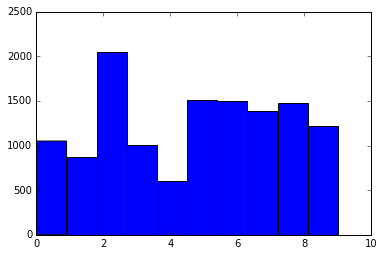

In [320]:
c = 4
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and distance(r, c) < 1.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 2

1240


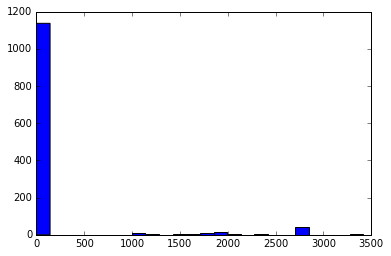

In [321]:
c = 2
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [322]:
c = 2
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
print dists[:30]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


12550


[1050, 874, 1939, 1002, 597, 1514, 1495, 1385, 1478, 1216]

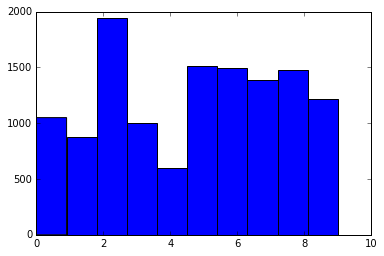

In [323]:
c = 2
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and distance(r, c) < 0.1))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 9

781


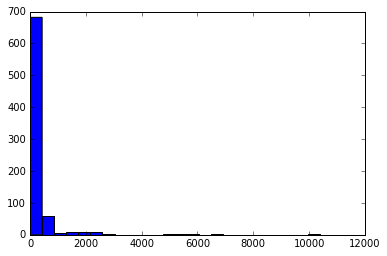

In [324]:
c = 9
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

12428


[1050, 874, 1939, 1002, 597, 1514, 1495, 1385, 1478, 1094]

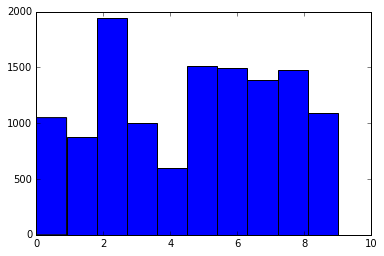

In [325]:
c = 9
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and distance(r, c) < 1.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 7

1082


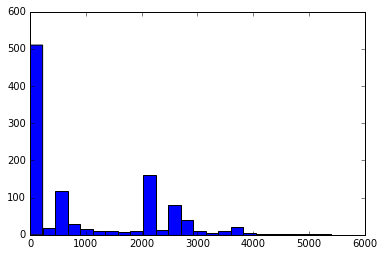

In [326]:
c = 7
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [327]:
dists[500:600]
incorrect.sort(key=lambda (x,y,q,r,rv): -distance(r,c))
incorrect[550:600]

[(u'../data/glebs-train/train/Sony-NEX-7/24513930567_55f14618b1_o.jpg',
  7,
  100,
  [3744, 5617],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/38142165914_cda10d75f7_o.jpg',
  7,
  99,
  [3540, 6000],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/38685299801_bef6ff20fb_o.jpg',
  7,
  96,
  [3750, 5625],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/37541197882_14bca12c58_o.jpg',
  7,
  99,
  [5635, 3737],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/38653248512_b91ed4e845_o.jpg',
  7,
  96,
  [5630, 3753],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/37967530344_a1f8336856_o.jpg',
  7,
  96,
  [5646, 3764],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/37112580226_c98fb4c5c2_o.jpg',
  7,
  96,
  [5600, 4000],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/38110805492_fa9f7b999a_o.jpg',
  7,
  93,
  [3603, 6000],
  False),
 (u'../data/glebs-train/train/Sony-NEX-7/37967044094_7f21ef19e5_o.jpg',
  7,
  96,
  [5697, 3798],
  False),
 (u'../data/glebs-

11839


[1050, 874, 1939, 1002, 597, 1514, 1495, 796, 1478, 1094]

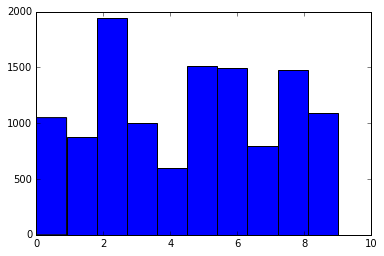

In [328]:
c = 7
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and distance(r, c) < 1.))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 5

1229


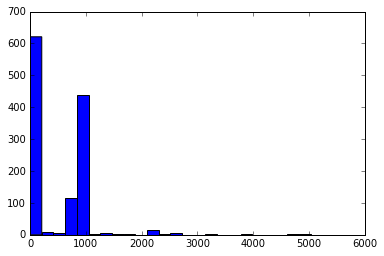

In [329]:
c = 5
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [330]:
dists[:9]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
dists[-30:]#, dists[230:260]

In [332]:
incorrect.sort(key=lambda (x,y,q,r,rv): -distance(r,5))
incorrect[130:140]

[(u'../data/glebs-train/train/Samsung-Galaxy-Note3/35117221375_929f93ce27_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35117221805_b6d7eaaf7a_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35117222025_ef03a23839_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35117222445_45b64bb3fe_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35117222905_5aa70485e9_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35231019683_321c9f0a34_o.jpg',
  5,
  93,
  [3264, 1836],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35569476706_12ecc6623c_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Note3/35754448775_772a29eaca_o.jpg',
  5,
  96,
  [1836, 3264],
  False),
 (u'../data/glebs-train/train/Samsung-Galaxy-Not

### same ratio as in training set, keep

11774


[1050, 874, 1939, 1002, 597, 1449, 1495, 796, 1478, 1094]

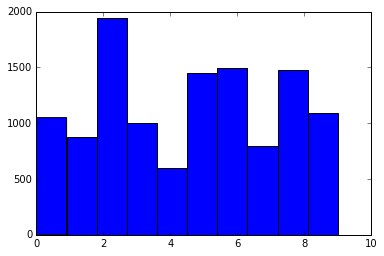

In [333]:
c = 5
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and ((distance(r, c) < 1.) or (773. < distance(r, c) < 992.))))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 0

33


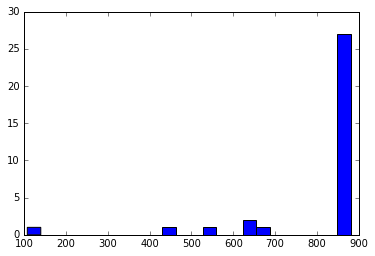

In [334]:
c = 0
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

#### simply remove all incorrect

11741


[1017, 874, 1939, 1002, 597, 1449, 1495, 796, 1478, 1094]

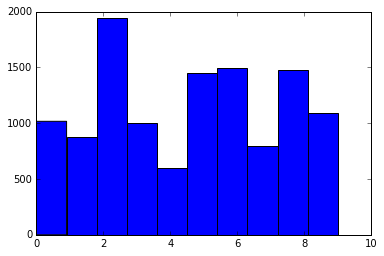

In [335]:
c = 0
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and rv), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 1

206


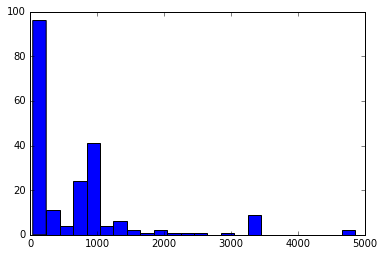

In [336]:
c = 1
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [337]:
dists[:20]

[40.0,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045,
 45.254833995939045]

11624


[1017, 757, 1939, 1002, 597, 1449, 1495, 796, 1478, 1094]

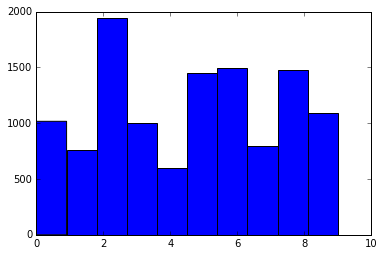

In [338]:
c = 1
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and (distance(r, c) < 46.)))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

### class 3

175


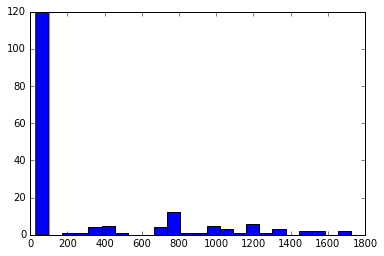

In [339]:
c = 3
incorrect = filter(lambda (x,y,q,r,rv): not rv and y == c, train)
print len(incorrect)
dists = map(lambda (x,y,q,r,rv): distance(r, c), incorrect)
dists.sort()
plt.hist(dists, bins=24);

In [340]:
dists[100:130]

[30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 35.777087639996637,
 185.77674773770801,
 282.85155117128136,
 316.42534664593478,
 329.13371143047624,
 338.00147928670373,
 364.9438312946254,
 403.27162062312294,
 416.20307543313515,
 430.83639586274512,
 449.44410108488466]

11449


[1017, 757, 1939, 827, 597, 1449, 1495, 796, 1478, 1094]

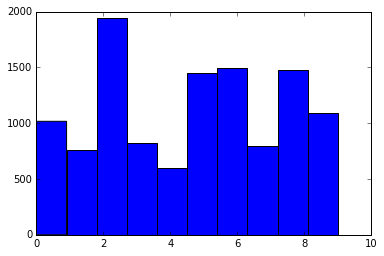

In [341]:
c = 3
train = filter(lambda (x,y,q,r,rv): y != c or (y == c and (rv or (not rv and (distance(r, c) < 1.)))), train)
print len(train)
TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

In [342]:
M = max(TRAIN_CLASSES)
m = min(TRAIN_CLASSES)
(M - m) / float(M)

0.6921093347086127

In [343]:
len(train)

11449

## NEW: filter using EXIF

In [344]:
train_with_exif = []
for x,y,q,r,rv in progress_iter(train, True):
    tags = exifread.process_file(open(x, 'rb'))
    train_with_exif.append((x,y,q,r,rv,tags))

A Jupyter Widget

In [350]:
train = train_with_exif

In [351]:
'Image Make'
'Image Model'
'Lens Make'
# distance((int(str(t['EXIF ExifImageWidth'])), int(str(t['EXIF ExifImageLength']))), c) > 0.1
# 'Image Orientation'

'Lens Make'

### class 0

In [352]:
c = 0
c_train = filter(lambda (x,y,q,r,rv,tags): y == c, train)
print len(c_train)

1017


In [353]:
str(c_train[0][5]['Image Orientation'])

'Horizontal (normal)'

In [354]:
c1 = lambda t: 'EXIF ExifImageWidth' in t
c2 = lambda t: 'EXIF ExifImageLength' in t
c3 = lambda t: distance((int(str(t['EXIF ExifImageWidth'])), int(str(t['EXIF ExifImageLength']))), c) < 0.1
cond = [
    lambda t: str(t['Image Make']) == 'HTC',
    lambda t: str(t['Image Model']) == 'HTC One',
    lambda t: c1(t) and c2(t) and c3(t),
    lambda t: 'Image Orientation' in t and str(t['Image Orientation']) == 'Horizontal (normal)'
]
all_cond = lambda (x,y,q,r,rv,t): all(map(lambda c: c(t), cond))
print len(filter(all_cond, c_train))

994


In [355]:
print len(train)
train = filter(lambda (x,y,q,r,rv,tags): y != c or all_cond((x,y,q,r,rv,tags)), train)
print len(train)

11449
11426


### class 1

In [356]:
c = 1
c_train = filter(lambda (x,y,q,r,rv,tags): y == c, train)
print len(c_train)

757


In [363]:
c1 = lambda t: 'EXIF ExifImageWidth' in t
c2 = lambda t: 'EXIF ExifImageLength' in t
c3 = lambda t: distance((int(str(t['EXIF ExifImageWidth'])), int(str(t['EXIF ExifImageLength']))), c) < 0.1
cond = [
    lambda t: 'Image Make' in t and str(t['Image Make']) == 'LGE',
    lambda t: 'Image Model' in t and str(t['Image Model']) == 'Nexus 5X',
    lambda t: c1(t) and c2(t) and c3(t),
#     lambda t: 'Image Orientation' in t and str(t['Image Orientation']) == 'Horizontal (normal)'
]
all_cond = lambda (x,y,q,r,rv,t): all(map(lambda c: c(t), cond))
print len(filter(all_cond, c_train))

662


In [366]:
print len(train)
train = filter(lambda (x,y,q,r,rv,tags): y != c or all_cond((x,y,q,r,rv,tags)), train)
print len(train)

11426
11331


### class 2

In [367]:
c = 2
c_train = filter(lambda (x,y,q,r,rv,tags): y == c, train)
print len(c_train)

1939


In [380]:
print list(set([str(t['Image Model']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))

['XT1080']


In [382]:
c1 = lambda t: 'EXIF ExifImageWidth' in t
c2 = lambda t: 'EXIF ExifImageLength' in t
c3 = lambda t: distance((float(str(t['EXIF ExifImageWidth'])), float(str(t['EXIF ExifImageLength']))), c) < 0.1
cond = [
    lambda t: 'Image Make' in t and str(t['Image Make']) == 'Motorola',
    lambda t: 'Image Model' in t and str(t['Image Model']) == 'XT1080',
    lambda t: c1(t) and c2(t) and c3(t),
#     lambda t: 'Image Orientation' in t and str(t['Image Orientation']) == 'Horizontal (normal)'
]
all_cond = lambda (x,y,q,r,rv,t): all(map(lambda c: c(t), cond))
print len(filter(all_cond, c_train))

801


In [383]:
print len(train)
train = filter(lambda (x,y,q,r,rv,tags): y != c or all_cond((x,y,q,r,rv,tags)), train)
print len(train)

11331
10193


### class 3

In [384]:
c = 3
c_train = filter(lambda (x,y,q,r,rv,tags): y == c, train)
print len(c_train)

827


In [385]:
print list(set([str(t['Image Make']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))

['motorola']


In [386]:
print list(set([str(t['Image Model']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))

['Nexus 6']


In [387]:
c1 = lambda t: 'EXIF ExifImageWidth' in t
c2 = lambda t: 'EXIF ExifImageLength' in t
c3 = lambda t: distance((float(str(t['EXIF ExifImageWidth'])), float(str(t['EXIF ExifImageLength']))), c) < 0.1
cond = [
    lambda t: 'Image Make' in t and str(t['Image Make']) == 'motorola',
    lambda t: 'Image Model' in t and str(t['Image Model']) == 'Nexus 6',
    lambda t: c1(t) and c2(t) and c3(t),
#     lambda t: 'Image Orientation' in t and str(t['Image Orientation']) == 'Horizontal (normal)'
]
all_cond = lambda (x,y,q,r,rv,t): all(map(lambda c: c(t), cond))
print len(filter(all_cond, c_train))

793


In [388]:
print len(train)
train = filter(lambda (x,y,q,r,rv,tags): y != c or all_cond((x,y,q,r,rv,tags)), train)
print len(train)

10193
10159


### class 4

In [389]:
c = 4
c_train = filter(lambda (x,y,q,r,rv,tags): y == c, train)
print len(c_train)

597


In [390]:
print list(set([str(t['Image Make']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))

['Motorola']


In [391]:
print list(set([str(t['Image Model']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))

['XT1096']


In [392]:
c1 = lambda t: 'EXIF ExifImageWidth' in t
c2 = lambda t: 'EXIF ExifImageLength' in t
c3 = lambda t: distance((float(str(t['EXIF ExifImageWidth'])), float(str(t['EXIF ExifImageLength']))), c) < 0.1
cond = [
    lambda t: 'Image Make' in t and str(t['Image Make']) == 'Motorola',
    lambda t: 'Image Model' in t and str(t['Image Model']) == 'XT1096',
    lambda t: c1(t) and c2(t) and c3(t),
#     lambda t: 'Image Orientation' in t and str(t['Image Orientation']) == 'Horizontal (normal)'
]
all_cond = lambda (x,y,q,r,rv,t): all(map(lambda c: c(t), cond))
print len(filter(all_cond, c_train))

595


In [393]:
print len(train)
train = filter(lambda (x,y,q,r,rv,tags): y != c or all_cond((x,y,q,r,rv,tags)), train)
print len(train)

10159
10157


### class 5

In [394]:
c = 5
c_train = filter(lambda (x,y,q,r,rv,tags): y == c, train)
print len(c_train)

1449


In [395]:
print list(set([str(t['Image Make']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))
print list(set([str(t['Image Model']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))

['samsung', 'SAMSUNG']
['SAMSUNG-SM-N900A']


In [399]:
print list(set([str(t['Image Model']) for x,y,q,r,rv,t in c_train]))

['SAMSUNG-SM-N900A', 'SM-N9005']


In [401]:
print list(set([str(t['EXIF ExifImageWidth']) for x,y,q,r,rv,t in c_train]))

['[4601, 0]', '2322', '[3264, 0]', '4128', '3210', '3399', '3142', '3264', '1836']


In [403]:
def f(v):
    return float(str(v).replace(', 0]', '').replace('[', ''))

In [407]:
c1 = lambda t: 'EXIF ExifImageWidth' in t
c2 = lambda t: 'EXIF ExifImageLength' in t
c3 = lambda t: distance((f(t['EXIF ExifImageWidth']), f(t['EXIF ExifImageLength'])), c) < 0.1
cond = [
    lambda t: 'Image Make' in t and str(t['Image Make']).lower() == 'samsung',
    lambda t: 'Image Model' in t and str(t['Image Model']) in ['SAMSUNG-SM-N900A', 'SM-N9005'],
    lambda t: c1(t) and c2(t) and c3(t),
#     lambda t: 'Image Orientation' in t and str(t['Image Orientation']) == 'Horizontal (normal)'
]
all_cond = lambda (x,y,q,r,rv,t): all(map(lambda c: c(t), cond))
print len(filter(all_cond, c_train))

903


In [408]:
print len(train)
train = filter(lambda (x,y,q,r,rv,tags): y != c or all_cond((x,y,q,r,rv,tags)), train)
print len(train)

10157
9611


### class 6

In [409]:
c = 6
c_train = filter(lambda (x,y,q,r,rv,tags): y == c, train)
print len(c_train)

1495


In [410]:
print list(set([str(t['Image Make']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))
print list(set([str(t['Image Model']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))

['samsung']
['SCH-I545']


In [414]:
print list(set([str(t.get('Image Model', None)) for x,y,q,r,rv,t in c_train]))

['GT-I9505', 'SCH-I545', 'None', 'GT-I9500']


In [415]:
c1 = lambda t: 'EXIF ExifImageWidth' in t
c2 = lambda t: 'EXIF ExifImageLength' in t
c3 = lambda t: distance((f(t['EXIF ExifImageWidth']), f(t['EXIF ExifImageLength'])), c) < 0.1
cond = [
    lambda t: 'Image Make' in t and str(t['Image Make']).lower() == 'samsung',
    lambda t: 'Image Model' in t and str(t['Image Model']) in ['GT-I9505', 'SCH-I545', 'GT-I9500'],
    lambda t: c1(t) and c2(t) and c3(t),
#     lambda t: 'Image Orientation' in t and str(t['Image Orientation']) == 'Horizontal (normal)'
]
all_cond = lambda (x,y,q,r,rv,t): all(map(lambda c: c(t), cond))
print len(filter(all_cond, c_train))

1493


In [416]:
print len(train)
train = filter(lambda (x,y,q,r,rv,tags): y != c or all_cond((x,y,q,r,rv,tags)), train)
print len(train)

9611
9609


### class 7

In [417]:
c = 7
c_train = filter(lambda (x,y,q,r,rv,tags): y == c, train)
print len(c_train)

796


In [418]:
print list(set([str(t['Image Make']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))
print list(set([str(t['Image Model']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))

['SONY']
['NEX-7']


In [421]:
c1 = lambda t: 'EXIF ExifImageWidth' in t
c2 = lambda t: 'EXIF ExifImageLength' in t
c3 = lambda t: distance((f(t['EXIF ExifImageWidth']), f(t['EXIF ExifImageLength'])), c) < 0.1
cond = [
    lambda t: 'Image Make' in t and str(t['Image Make']) == 'SONY',
    lambda t: 'Image Model' in t and str(t['Image Model']) == 'NEX-7',
    lambda t: c1(t) and c2(t) and c3(t),
#     lambda t: 'Image Orientation' in t and str(t['Image Orientation']) == 'Horizontal (normal)'
]
all_cond = lambda (x,y,q,r,rv,t): all(map(lambda c: c(t), cond))
print len(filter(all_cond, c_train))

757


In [422]:
print len(train)
train = filter(lambda (x,y,q,r,rv,tags): y != c or all_cond((x,y,q,r,rv,tags)), train)
print len(train)

9609
9570


### class 8

In [423]:
c = 8
c_train = filter(lambda (x,y,q,r,rv,tags): y == c, train)
print len(c_train)

1478


In [434]:
print list(set([str(t['Image Make']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))
print list(set([str(t['Image Model']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))
print list(set([str(t['EXIF LensMake']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))
print list(set([str(t['EXIF LensModel']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))

['Apple']
['iPhone 4S']
['Apple']
['iPhone 4S back camera 4.28mm f/2.4']


In [437]:
c1 = lambda t: 'EXIF ExifImageWidth' in t
c2 = lambda t: 'EXIF ExifImageLength' in t
c3 = lambda t: distance((f(t['EXIF ExifImageWidth']), f(t['EXIF ExifImageLength'])), c) < 0.1
cond = [
    lambda t: 'Image Make' in t and str(t['Image Make']) == 'Apple',
    lambda t: 'Image Model' in t and str(t['Image Model']) == 'iPhone 4S',
    lambda t: 'EXIF LensMake' in t and str(t['EXIF LensMake']) == 'Apple',
    lambda t: 'EXIF LensModel' in t and str(t['EXIF LensModel']) == 'iPhone 4S back camera 4.28mm f/2.4',
    lambda t: c1(t) and c2(t) and c3(t),
#     lambda t: 'Image Orientation' in t and str(t['Image Orientation']) == 'Horizontal (normal)'
]
all_cond = lambda (x,y,q,r,rv,t): all(map(lambda c: c(t), cond))
print len(filter(all_cond, c_train))

888


In [438]:
print len(train)
train = filter(lambda (x,y,q,r,rv,tags): y != c or all_cond((x,y,q,r,rv,tags)), train)
print len(train)

9570
8980


### class 9

In [439]:
c = 9
c_train = filter(lambda (x,y,q,r,rv,tags): y == c, train)
print len(c_train)

1094


In [440]:
print list(set([str(t['Image Make']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))
print list(set([str(t['Image Model']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))
print list(set([str(t['EXIF LensMake']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))
print list(set([str(t['EXIF LensModel']) for x,y,q,r,rv,t in c_train if 'data/train' in x]))

['Apple']
['iPhone 6']
['Apple']
['iPhone 6 back camera 4.15mm f/2.2']


In [441]:
c1 = lambda t: 'EXIF ExifImageWidth' in t
c2 = lambda t: 'EXIF ExifImageLength' in t
c3 = lambda t: distance((f(t['EXIF ExifImageWidth']), f(t['EXIF ExifImageLength'])), c) < 0.1
cond = [
    lambda t: 'Image Make' in t and str(t['Image Make']) == 'Apple',
    lambda t: 'Image Model' in t and str(t['Image Model']) == 'iPhone 6',
    lambda t: 'EXIF LensMake' in t and str(t['EXIF LensMake']) == 'Apple',
    lambda t: 'EXIF LensModel' in t and str(t['EXIF LensModel']) == 'iPhone 6 back camera 4.15mm f/2.2',
    lambda t: c1(t) and c2(t) and c3(t),
#     lambda t: 'Image Orientation' in t and str(t['Image Orientation']) == 'Horizontal (normal)'
]
all_cond = lambda (x,y,q,r,rv,t): all(map(lambda c: c(t), cond))
print len(filter(all_cond, c_train))

1081


In [442]:
print len(train)
train = filter(lambda (x,y,q,r,rv,tags): y != c or all_cond((x,y,q,r,rv,tags)), train)
print len(train)

8980
8967


### TODO: finally fill validation set up from filtered train (q $\geq$ 95)

[48, 48, 48, 48, 48, 48, 48, 48, 48, 48]

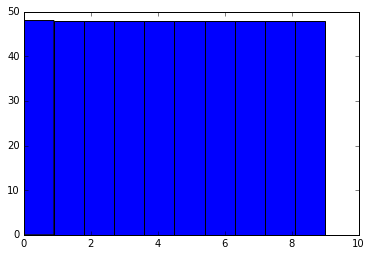

In [444]:
RNG(seed=777).shuffle(train)
new_train = []
for x,y,q,r,rv,_ in train:
    VAL_CLASSES = np.bincount(zip(*val)[1])
    if q >= 95 and VAL_CLASSES[y] < N_VAL_PER_CLASS:
        val.append((x, y))
    else:
        new_train.append((x,y,q,r,rv))

train = new_train
        
VAL_CLASSES = map(int, plt.hist(zip(*val)[1])[0])
VAL_CLASSES

0.692109334709
8847


[991, 651, 767, 773, 595, 873, 1490, 751, 888, 1068]

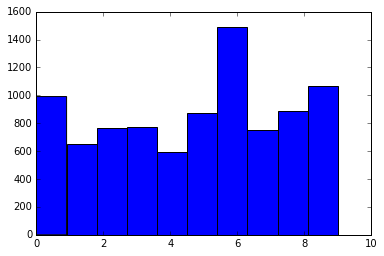

In [445]:
M = max(TRAIN_CLASSES)
m = min(TRAIN_CLASSES)
print (M - m) / float(M)
print len(train)

TRAIN_CLASSES = map(int, plt.hist(zip(*train)[1])[0])
TRAIN_CLASSES

## now need to crop and to save images to disk, but now cleverer:
### $\approx$ undersampling, save separate blocks (of $\approx$ same size) for each class

In [446]:
BLOCK_SIZE = 48
N_BLOCKS = [int(np.round(t/float(BLOCK_SIZE))) for t in TRAIN_CLASSES]
N_BLOCKS

[21, 14, 16, 16, 12, 18, 31, 16, 18, 22]

In [ ]:
crop_size = 1024
for c in xrange(10):
    if c == 3:
        continue
    class_train = filter(lambda (x,y,q,r,rv): y == c, train)
    RNG(seed=7331 + c).shuffle(class_train)
    class_blocks = []
    for _ in xrange(N_BLOCKS[c]):
        class_blocks.append([])
    pos = 0
    for x,_,_,_,_ in progress_iter(class_train, True):
        x = Image.open(x)
        w = x.size[0]
        h = x.size[1]
        x = x.crop((w/2-crop_size/2, h/2-crop_size/2,
                    w/2+crop_size/2, h/2+crop_size/2))
        class_blocks[pos % N_BLOCKS[c]].append(np.asarray(x, dtype=np.uint8))
        pos += 1
    for b in xrange(N_BLOCKS[c]):
        np.save('../data/X_{0}_{1}.npy'.format(c, b), np.asarray(class_blocks[b], dtype=np.uint8))

### save validation set

In [81]:
len(val)

480

In [82]:
RNG(seed=9999).shuffle(val)

In [83]:
y_val = np.asarray(zip(*val)[1])
crop_size = c = 1024
X_val = np.zeros((len(y_val), crop_size, crop_size, 3), dtype=np.uint8)
pos = 0
for x, _ in progress_iter(val, True):
    x = Image.open(x)
    w = x.size[0]
    h = x.size[1]
    x = x.crop((w/2-c/2, h/2-c/2,
                w/2+c/2, h/2+c/2))
    X_val[pos] = np.asarray(x, dtype=np.uint8)
    pos += 1
np.save('../data/X_val.npy', X_val)
np.save('../data/y_val.npy', y_val)

A Jupyter Widget

### split validation for training, validation

In [95]:
N_VAL_TRAIN_PER_CLASS = 24
N_VAL_TRAIN = N_VAL_TRAIN_PER_CLASS * 10
D = 1024
d = 512
X_val_train = np.zeros((N_VAL_TRAIN, D, D, 3), dtype=np.uint8)
X_val_val = np.zeros((len(y_val) - N_VAL_TRAIN, d, d, 3), dtype=np.uint8)
y_val_train = []
y_val_val = []
pos_val_train = 0
pos_val_val = 0
for i in xrange(len(y_val)):
    c = y_val[i]
    if y_val_train.count(c) < N_VAL_TRAIN_PER_CLASS:
        X_val_train[pos_val_train] = X_val[i]
        pos_val_train += 1
        y_val_train.append(c)
    else:
        X_val_val[pos_val_val] = X_val[i][D/2-d/2:D/2+d/2, D/2-d/2:D/2+d/2, :]
        pos_val_val += 1
        y_val_val.append(c)

In [106]:
np.save('../data/X_val_train.npy', X_val_train)
np.save('../data/y_val_train.npy', np.asarray(y_val_train))
np.save('../data/X_val_val.npy', X_val_val)
np.save('../data/y_val_val.npy', np.asarray(y_val_val))

### [!!!] cyclicly add `X_val_train` to all blocks

In [107]:
X_val_train = np.load('../data/X_val_train.npy')
y_val_train = np.load('../data/y_val_train.npy')
print X_val_train.shape

(240, 1024, 1024, 3)


In [3]:
N_BLOCKS = [21, 16, 16, 17, 12, 19, 31, 16, 31, 23]

In [127]:
for c in xrange(10):
    print c
    c_ind = np.arange(len(y_val_train))[y_val_train == 0]
    for block_num, i in enumerate(c_ind):
        block_num = block_num % N_BLOCKS[c]
        X_block = np.load('X_{0}_{1}.npy'.format(c, block_num))
        X_block = np.concatenate((X_block, X_val_train[i].reshape((1, 1024, 1024, 3))))
        N_IMAGES_PER_CLASS[c] -= len(X_block)
        np.save('X_{0}_{1}.npy'.format(c, block_num), X_block)
        
print N_IMAGES_PER_CLASS

### check count

In [4]:
N_IMAGES_PER_CLASS = [1014, 746, 767, 807, 598, 918, 1492, 790, 1478, 1081]
for i in xrange(10):
    N_IMAGES_PER_CLASS[i] += 24

In [ ]:
for c in xrange(10):
    for b in xrange(N_BLOCKS[c]):
        N_IMAGES_PER_CLASS[c] -= len(np.load('../data/X_{0}_{1}.npy'.format(c, b)))
    print c, N_IMAGES_PER_CLASS[c]
print N_IMAGES_PER_CLASS